# Ghost point clound data of a mesh

So Christophe Leterier[@christlet](https://twitter.com/christlet) and Felix Voilzel [@Flexi23](https://twitter.com/Flexi23) made this:

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">I gave data to <a href="https://twitter.com/Flexi23">@Flexi23</a> and he developed... a SMLM 3D viewer in your web browser! This is excellencredible <a href="https://t.co/pTqUGlXVV6">pic.twitter.com/pTqUGlXVV6</a></p>&mdash; Christophe Leterrier (@christlet) <a href="https://twitter.com/christlet/status/791642533059293184">October 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Now I have to try to generate a point cloud in the crorect format...

### Loading a tyssue dataset 

In [1]:
import pandas as pd
import numpy as np

from tyssue.io import hdf5
from tyssue import config
from tyssue.core.monolayer import Monolayer

import matplotlib.pyplot as plt
%matplotlib qt
import seaborn as sns

In [3]:
datasets = hdf5.load_datasets('../tyssue/small_ellipsoid.hf5',
                              data_names=['vert', 'edge',
                                          'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


## Generating particles from the edges


The idea is to simulate a STORM experiment, assuming our fluorophore is distributed along the edges.

Given the edge from the vertex at $\mathbf{r}_i$ to the one at $\mathbf{r}_j$, the possible positions of the particles are given by:

$$\mathbf{u}(s_{ij}) = \mathbf{r}_i + \mathbf{r}_{ij} \frac{s_{ij}}{\ell_{ij}}, \quad s \in (0, \ell_{ij})$$

Let $\delta_s$ be the spacing between two fluorphores, then we have $n_{ij} = \ell_{ij}/\delta_s$ fluorophores per edge.  
 

In [18]:
mean_length = monolayer.edge_df.length.mean()
delta_s = 0.1 * mean_length

mesh = monolayer.edge_df[['length',] + monolayer.dcoords].copy()
mesh['num_particles'] = (monolayer.edge_df.length/delta_s).astype(np.int)

srce_pos = monolayer.upcast_srce(
        monolayer.vert_df[monolayer.coords])

for c in monolayer.coords:
    mesh[c] = srce_pos[c]
    mesh['_'+c] = mesh.eval('{}/{}'.format(
            c, 'd'+c, 'length')) 
    
columns = ['frame', 'x [nm]', 'y [nm]', 'z [nm]',
           'uncertainty_xy', 'uncertainty_z']


n_points = mesh['num_particles'].sum()
points = pd.DataFrame(np.zeros((n_points, 
                                monolayer.ncoords)), 
                      columns=columns)

curv_indexer = np.repeat(np.arange(mesh.shape[0]), 
                         mesh['num_particles'])
ramps = np.concatenate([np.arange(0, 1, ns) 
                        for ns in mesh['num_particles']])
for c in monolayer.coords:
    points[c+' [nm]'] = srce_pos.loc[curv_indexer] + 

upcast_nij = mesh['num_particles'].loc[curv_indexer]
assert curv_indexer.max() + 1 == mesh.shape[0]





#curv_coord =  

print('N edges: {}, N points: {}'.format(mesh.shape[0],
                                         curv_indexer.shape[0]))



def particles(edge):
    part_idx = edge['length']
    return 


N edges: 1656, N points: 15722


In [19]:
ramps

array([ 0.    ,  0.125 ,  0.25  , ...,  0.875 ,  0.9375,  1.    ])

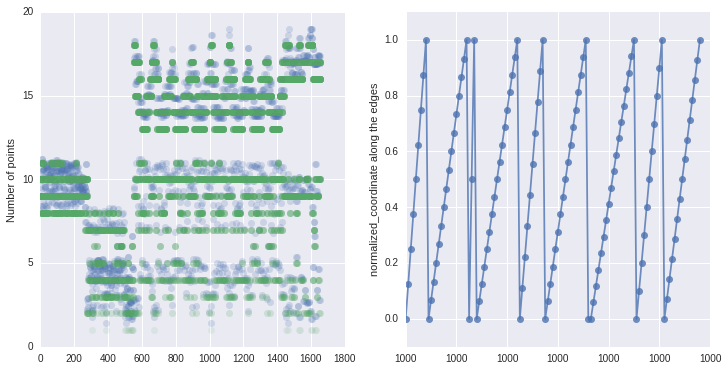

In [35]:

%matplotlib inline
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.plot(mesh.length.values/delta_s, 'o', alpha=0.2)
ax0.plot(upcast_nij, 'o', alpha=0.1)
ax0.set_ylabel('Number of points')

e_start, e_stop = 1000, 1010

p_start, p_stop = (curv_indexer[curv_indexer < e_start].size,
                   curv_indexer[curv_indexer < e_stop].size )

ax1.plot(ramps[p_start: p_stop], '-o', alpha=0.8)
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel('normalized coordinate along the edges')

fig.set_size_inches((12, 6))

### The 3D Storm format

In [8]:
ls ../tyssue/visualisation/

3D_STORM_format.png  Visualization.ipynb


![Crop of the 3D_STORM format in a tabulator](../tyssue/visualisation/3D_STORM_format.png)

In [4]:
exc = pd.io.excel.read_excel('3D-STORM.xls')

XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'"frame"\t'